In [1]:
#Set up environment and import necessary dependencies

%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple;
import numpy as np;

#Import some general util stuff
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

#import deepLIFT stuff
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/kerasBasedBackprop");
from deepLIFTonGPU import ScoreTypes, Activations_enum, OutLayerInfo, getScoreFunc

#Make sure the directory is set to import the lab's version of keras
scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)

/users/annashch/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using Theano backend.
Using gpu device 7: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5004)
/users/annashch/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
#load the data
import h5py 
data_file=h5py.File("/srv/scratch/annashch/deeplearning/heterokaryon/inputs/newpeaks.long.hdf5","r")
data_X=np.asarray(data_file["testX"])
data_Y=np.asarray(data_file["testY"])
data_Y.shape

(138636, 25)

In [3]:
modelsDir="/srv/scratch/annashch/deeplearning/heterokaryon/modelsDir_runsDbPeytonModel_AllPairs_2/"
modelWeights=modelsDir+"/record_82_model_mQtha_modelWeights.h5" 
modelYaml=modelsDir+"/record_82_model_mQtha_modelYaml.yaml" 

model = deepLIFTutils.loadKerasModel(modelWeights, modelYaml)
reload(deepLIFTutils);
deepLIFTutils.meanNormaliseFirstConvLayerWeights(model);

In [4]:
model.layers

In [5]:
import deepLIFTutils
reload(deepLIFTutils)


#Get all the outputs on the data set:
outputs = deepLIFTutils.getSequentialModelLayerOutputs(
                                        model
                                        , inputDatas=[data_X]
                                        , layerIdx=-1
                                        , batchSize=500)


('Done', 0)
('Done', 10000)
('Done', 20000)
('Done', 30000)
('Done', 40000)
('Done', 50000)
('Done', 60000)
('Done', 70000)
('Done', 80000)
('Done', 90000)
('Done', 100000)
('Done', 110000)
('Done', 120000)
('Done', 130000)


In [6]:
#Get the specific outputs for the task of interest 
neuronOfInterest_idx = 0 
outputs_singleNeuron = [x[neuronOfInterest_idx] for x in outputs];
trueLabels_singleNeuron = [x[neuronOfInterest_idx] for x in data_Y]

In [7]:
#If you set thresholdProb below to something other than 0.5, you
#would also be filtering for true positives whose predicted prob
#was greater than that threshold.
thresholdProb=0.5 #for neurons where we have too many peaks (memory issues!) raise the thresholdProb
truePositiveIndices=csi.getTruePositiveIndicesAboveThreshold(
                            outputs=outputs_singleNeuron
                            , trueLabels=trueLabels_singleNeuron
                            , thresholdProb=thresholdProb)



Deprecated; use deepLIFTutils.getTruePositiveIndicesAboveThreshold
CHECK THAT THIS LOOKS RIGHT!!
Proportion in various quadrants of confusion mat:
(first index is 'true label', second index is 'predicted')
(0, 0, 0.921918449644997)
(0, 1, 0.07808155035500301)
(1, 0, 0.4752714113389626)
(1, 1, 0.5247285886610374)
('After filtering for true predictions with prob above', 0.5, 'there are', 17835, 'down from', 17835, '(total pos:', 33989, 'of', 138636, ')')


In [8]:
#Compile the deepLIFT scoring function.
#'0' is specially interpreted to indicate the raw input layer - in this case the sequence. That's
#what we want to track. You can specify other layers - eg model.layers[0] will track the output
#of the first convooutputLayerIdx = 0; #idx of the output layer in outputLayers argument to compiling the scoreFunc abovelutional layer (before the nonlinearity is applied)
trackLayers = [0]
outputLayers = [OutLayerInfo(outLayNoAct=model.layers[-2],activation='sigmoid')]
import deepLIFTonGPU
reload(deepLIFTonGPU)
scoreFunc = deepLIFTonGPU.getScoreFunc(model, trackLayers, outputLayers, 
                          [ScoreTypes.deepLIFT_rawContrib,ScoreTypes.sensitivity]);

In [9]:
#Run the scoring function on the full valid+test set
reload(deepLIFTutils)
data_x_tp=data_X[truePositiveIndices]
data_y_tp=data_Y[truePositiveIndices]
allDLOutputOnData = deepLIFTutils.runScoreFuncOnData(batchSize=500
                                                          , data=data_x_tp[0:1000]
                                                          , scoreFunc=scoreFunc
                                                          , progressUpdate=500)

Data needs to be a list, one per input mode. Wrapping for you
('On', 0)
('On', 500)


In [10]:
#Obtain the deepLIFT raw contributions for the raw input for the outputLayer and outputNeuron that you want to study
#(This is (3) as described above)
trackLayerIdx = 0
outputLayerIdx = 0; #idx of the output layer in outputLayers argument to compiling the scoreFunc above

dLRawContribs_singleNeuron = allDLOutputOnData[ScoreTypes.deepLIFT_rawContrib]\
                                                    [outputLayerIdx]\
                                                    [trackLayerIdx]\
                                                    [neuronOfInterest_idx];
#make sure the shape looks right!
#should have dims: num examples x num channels x num rows x num cols
print(dLRawContribs_singleNeuron.shape)

(1000, 1, 4, 2000)


In [11]:
reload(csi)

#this is the probability threshold that we want to find the critical subset w.r.t.
#i.e. after including all negative contributions and the aggregate bias in the
#network, we find the smallest subset of positive deepLIFT contributions such that the
#output probability is > criticalSubsetThresholdProb
criticalSubsetThresholdProb = 1.0
#Prepare the subset of examples you want to compute the grammars on
#Below, we restrict our attention to only true positives.
indicesToGetGrammarsOn = truePositiveIndices;
#Tip: the initial stage is to compute a distance matrix between the grammars to identify
#clusters. You don't need to compute grammars on all the data for this, so for
#efficiency it may help to consider only a subset of the data.

#The segment identifier determines how a grammar ("segment") is extracted given the critical subset.
#(The segments will later be cross-correlated with each other to compute a confusion matrix, so it
# is preferable to keep them short)
#The algorithm used for the FixedWindowAroundPeaks identifier is as follows:
#   compute sums of the deepLIFT contributions in sliding window of size slidingWindowForMaxSize
#   find peaks (points whose sliding window sums are larger than their neighbours; for plateaus, take the middle)
#   filter out peaks which are not at least ratioToTopPeakToInclude of the tallest peak
#   for each peak in order of highest peak first:
#      add (peakStart-flankToExpandAroundPeakSize
#          , peakStart+slidingWindowForMaxSize+flankToExpandAroundPeakSize)
#      to your list of identified segments
#      filter out any peaks that are within excludePeaksWithinWindow of this peak to your list
#   loop until there are no more candidate peaks left or the total number of segments identified is maxSegments
segmentIdentifier = csi.FixedWindowAroundPeaks(
                        slidingWindowForMaxSize=20
                        , flankToExpandAroundPeakSize=5
                        , excludePeaksWithinWindow=20
                        , ratioToTopPeakToInclude=0.5
                        , maxSegments=5);
#This is now enough to identify the grammars. This function will return an array of
#crticalSubsetIdentification.Grammalr objects as well as an array of the indices
#(corresponding to indicesToGetGrammarOn) that each grammar came from
#(if you pick a segment identifier other than FullSegment, you can have multiple
#grammars per sequence)
grammars, grammarIndices = csi.getGrammars(
                                rawDeepLIFTContribs=dLRawContribs_singleNeuron
                                , indicesToGetGrammarsOn=None
                                , outputsBeforeActivation=None
                                , activation=None
                                , thresholdProb=criticalSubsetThresholdProb
                                , segmentIdentifier=segmentIdentifier
                                , numThreads=1
                                , secondsBetweenUpdates=1)


Get grammars is deprecated as the name was confusing; use getSeqlets
No reverse comp function provided so assuming you have dna as first 4 rows
Done 0 of 1000
Done 100 of 1000
Done 200 of 1000
Done 300 of 1000
Done 400 of 1000
Done 500 of 1000
Done 600 of 1000
Done 700 of 1000
Done 800 of 1000
Done 900 of 1000


In [4]:
reload(csi)
dLGradients_singleNeuron = allDLOutputOnData[ScoreTypes.sensitivity]\
                                                    [outputLayerIdx]\
                                                    [trackLayerIdx]\
                                                    [neuronOfInterest_idx];
dLGradients_singleNeuron = np.squeeze(dLGradients_singleNeuron,axis=1);
#augment tracks with gradient info and underlying sequence info
for dataToAugmentWith,name,pseudocount,revCompFunc in [(np.squeeze(data_x_tp[0:1000], axis=1)
                                             , "sequence"
                                             , 0.25
                                             , csi.dnaRevCompFunc)
                                           ,(dLGradients_singleNeuron
                                             , "gradients"
                                             , 0.0
                                             , csi.dnaRevCompFunc)]:
    csi.augmentGrammarsWithData(grammars, fullDataArr=\
                                        dataToAugmentWith
                                        , keyName=name
                                        , pseudocount=pseudocount
                                        , revCompFunc=revCompFunc
                                        #only provide indicesToSubset if the indices of grammarIndices
                                        #are actually an index into a subset of fullDataArr
                                        #in other words, if you provided an indicesToGetGrammarsOn
                                        #argument above, you probably don't need to provide anything here
                                        #for clarifcation, if provided, the indexes in the grammars 
                                        #will be looked up in indicesToSubset, and the result of THAT
                                        #lookup will be looked up in fullDataArr. If indiciesToGetGrammarsOn
                                        #was provided originally, then the indexes of the grammars will already
                                        #be correct
                                        , indicesToSubset=None)

NameError: name 'allDLOutputOnData' is not defined

In [13]:
print(len(grammarIndices)) # get a sense of the total number of grammars
print(grammarIndices[0:100]) # look at the indices of the first 100 grammars to get a sense
#of which grammars are from which examples

2119
[109, 671, 65, 19, 156, 163, 718, 106, 446, 380, 125, 258, 419, 528, 938, 936, 410, 275, 955, 615, 136, 763, 809, 654, 664, 459, 888, 144, 261, 142, 433, 135, 218, 287, 197, 670, 545, 20, 764, 270, 225, 712, 912, 28, 558, 49, 566, 900, 765, 441, 219, 0, 102, 831, 772, 139, 793, 680, 617, 866, 865, 216, 621, 827, 67, 422, 127, 652, 884, 677, 521, 215, 302, 879, 128, 151, 101, 536, 307, 116, 65, 784, 744, 757, 478, 188, 119, 417, 428, 207, 740, 80, 413, 797, 958, 789, 758, 537, 362, 184]


In [14]:
grammar_scores=[np.sum(grammars[i].summedCoreDeepLIFTtrack) for i in range(len(grammars))]


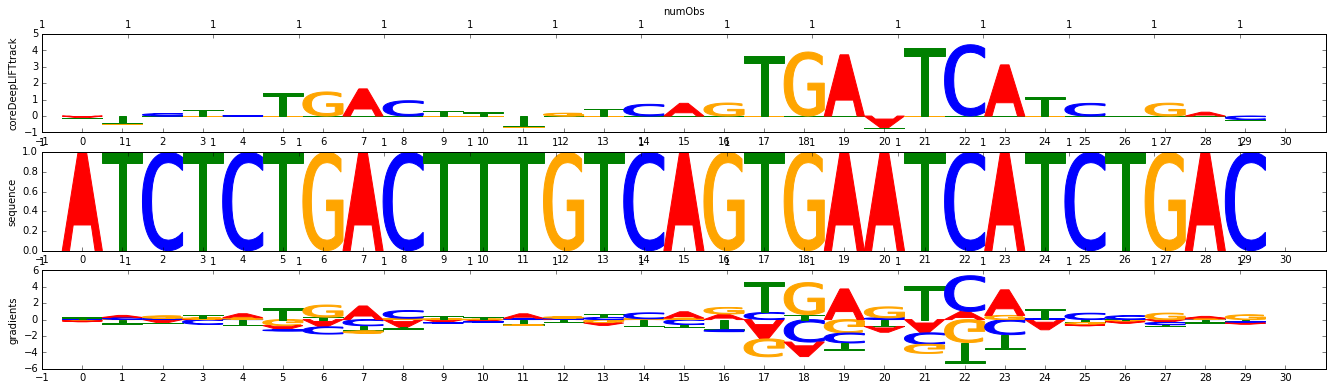

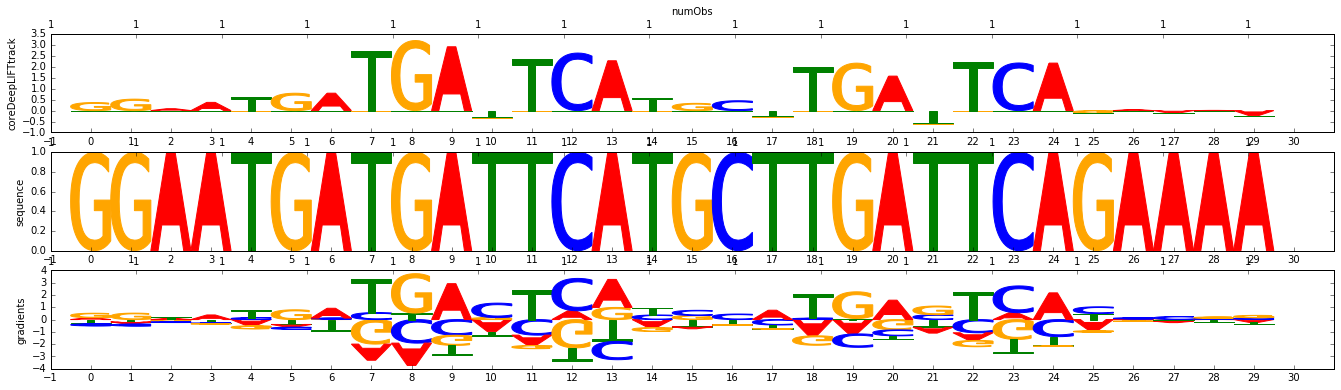

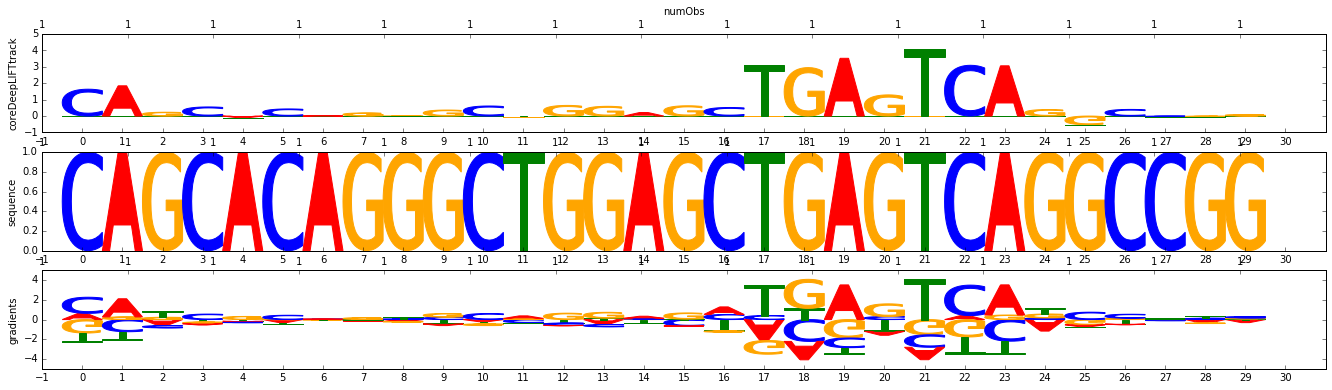

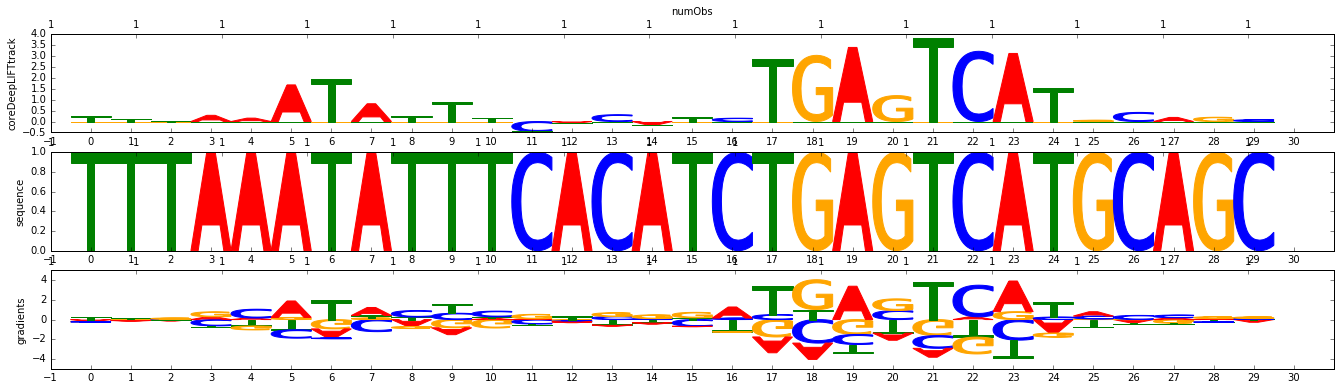

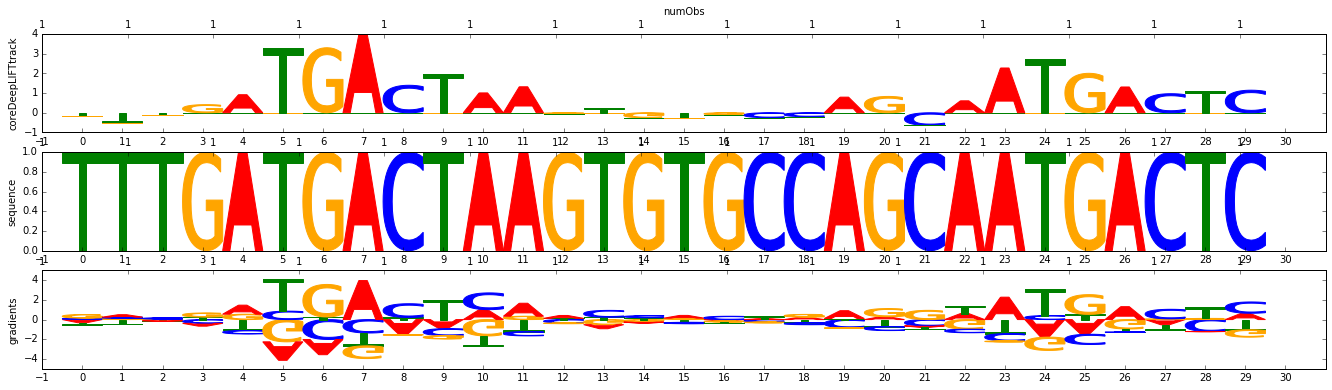

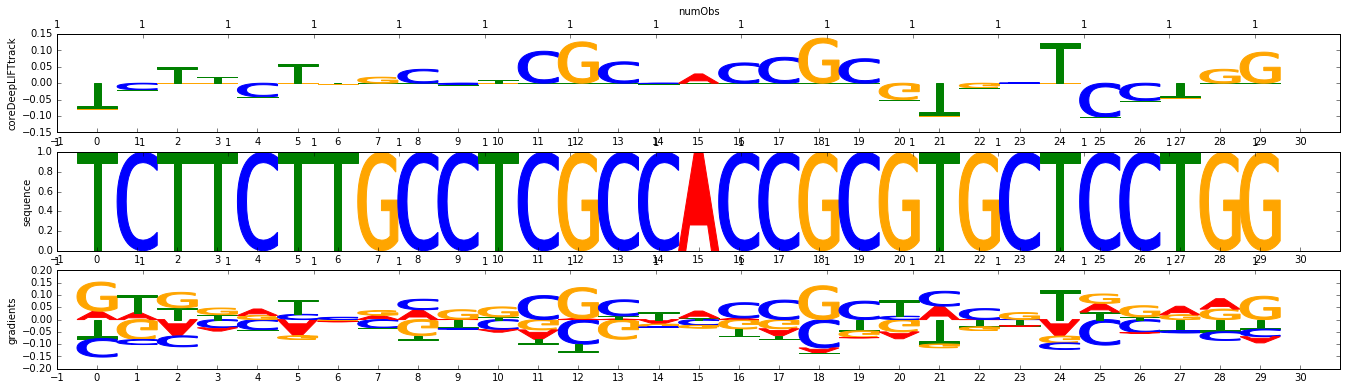

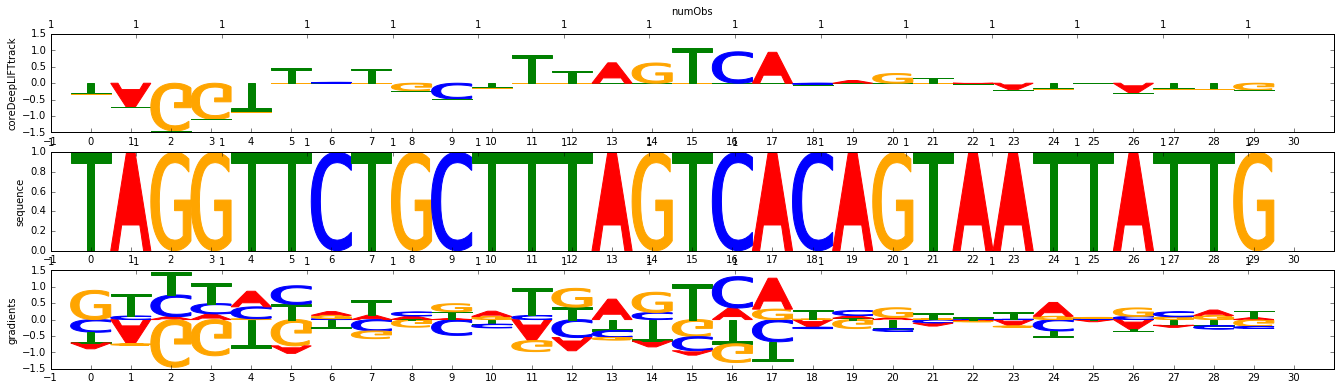

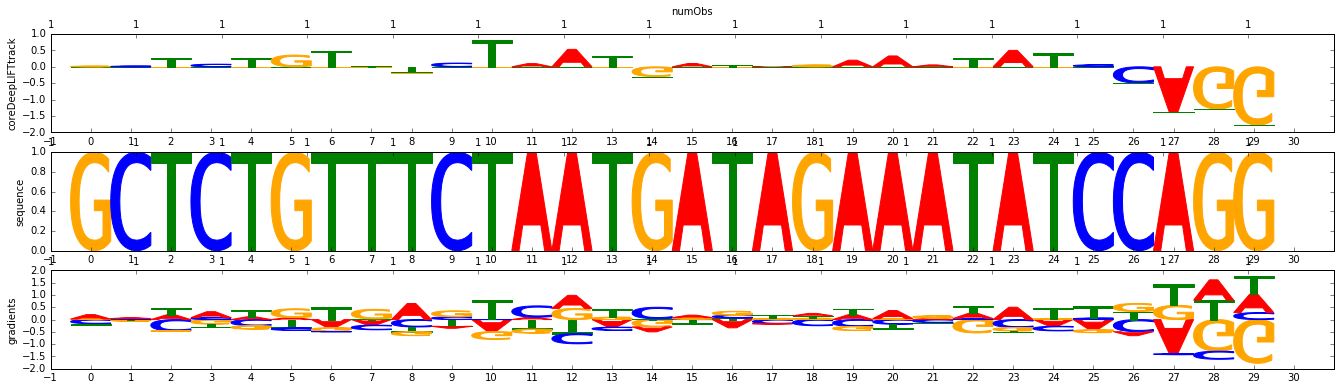

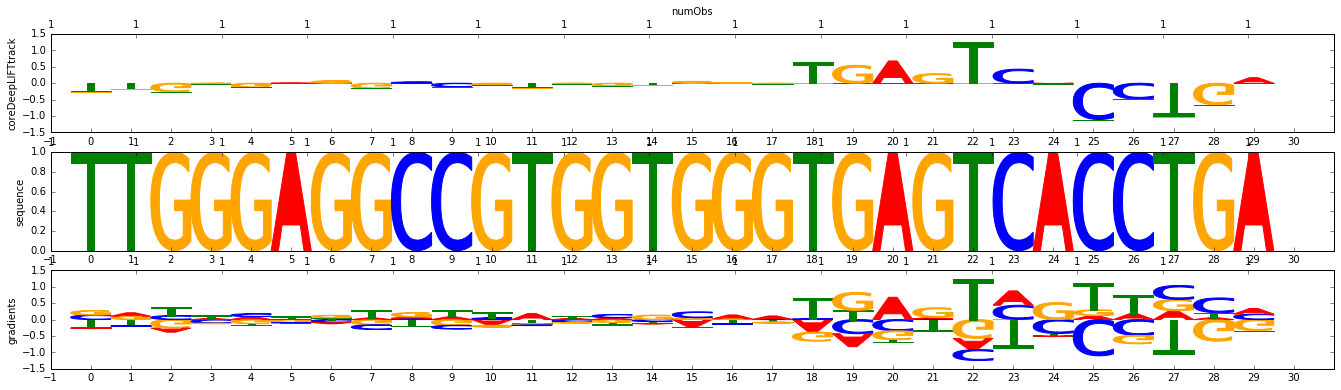

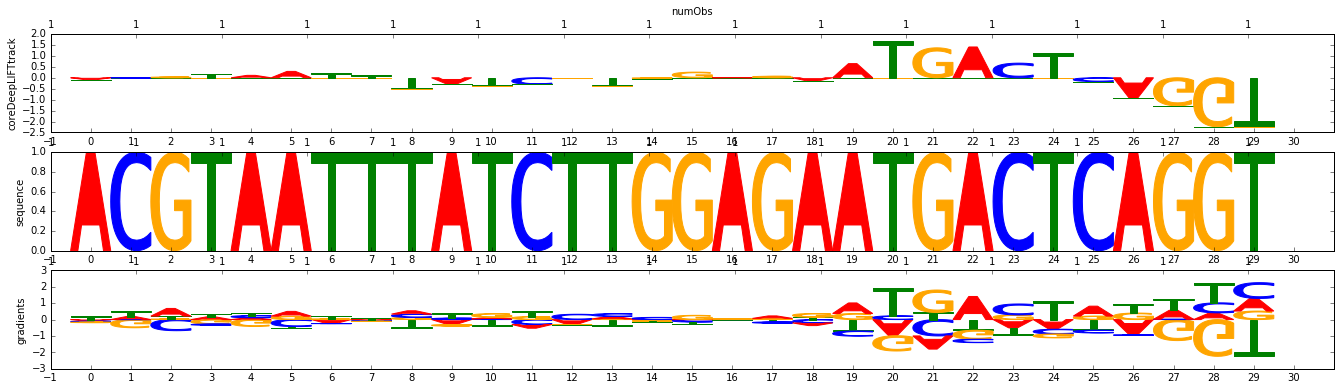

In [15]:
#visually explore the grammars originating from a few examples to get a sense of what they look like
reload(csi)
trackNamesToPrint=[csi.coreDeepLIFTtrackName, "sequence", "gradients"]
for idx in range(5):
    csi.printGrammarWithIdx(grammars, idx=idx, trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
for idx in range(-5,0):
    csi.printGrammarWithIdx(grammars, idx=idx, trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
    

In [16]:
#xcor code can currently only handle equally sized seqlets so filter out the few seqlets that were at the
#edge and are thus smaller
normalGrammarLen = np.max([x.summedCoreDeepLIFTtrack.shape[1] for x in grammars])
grammars = [x for x in grammars if x.summedCoreDeepLIFTtrack.shape[1]==normalGrammarLen]

In [ ]:
import time;
reload(csi)
reload(util)
sys.path.insert(0,"/usr/local/cuda/bin/");

#Compute the pairwise distance matrix between the grammars.
#This is by far the most time-consuming operation, so multithread.
#If it takes too long try subsetting to the top 1000 grammars. Remember for
#this step you don't need all the grammars, just a representative
#set for clustering.
#On my mac, for 1000 grammars of len 30bp and 4 threads, this
#took 90 seconds..but it *scales quadratically* so be careful
grammarsSubset = grammars[:1000]
accountForRevComp=True
#subtracksToInclude represents the set of subtracks to do the
#cross correlation based on. You could in theory do the
#cross correlation based on some of the augmented data tracks
#as well
#subtracksToInclude=[csi.Grammar.coreDeepLIFTtrackName]
subtracksToInclude=["gradients"]
os.environ['CUDA_DEVICE']="3" #you should set this if you plan to do xcor on the GPU
grammarsCorrMat = csi.getCorrelationMatrix(
                        grammarsSubset
                        , subtracksToInclude=subtracksToInclude
                        , accountForRevComp=accountForRevComp
                        , numThreads=1
                        , secondsBetweenUpdates=3
                        , xcorBatchSize=10 #set this to something other than None to do xcor on GPU
                        #, subtrackNormaliseFunc=util.CROSSC_NORMFUNC.perPositionRange
                        )

Num words: 1000
FFT size 128
FFT time: 0.141587972641
EWPMK time: 0.303980827332
ifft time: 0.8817050457
MAI time: 30.4722373486
FFT size 128
FFT time: 0.0104739665985
EWPMK time: 0.303102016449
ifft time: 0.867428302765
MAI time: 30.1247179508
Seconds to compute corr mat: 64.4461047649


In [ ]:
#find the t-sne embedding using the distance metric
reload(csi)
import sklearn
print(grammarsCorrMat.shape)
embedding = csi.getTsneEmbeddingOfGrammars(grammarsCorrMat, perplexity=30)
mplh.scatterPlot(embedding)
#tsne = manifold.TSNE(metric='precomputed', perplexity=30);
#grammarsDistMat = np.max(grammarsCorrMat)-grammarsCorrMat
#embedding = tsne.fit_transform(grammarsDistMat)
#import matplotlib.pyplot as plt
#plt.scatter(embedding[:,0], embedding[:,1])

In [ ]:
#spectral clustering
reload(csi)
reload(util)
labels = csi.getSpectralClustering(mat=grammarsCorrMat, n_clusters=10, affinity="precomputed");
labels=csi.colorTSNEembeddingBySpectralClustering(grammarsCorrMat, embedding, n_clusters=10)
outputFile='TSNE_task_'+str(neuronOfInterest_idx)+".png"


In [ ]:
reload(deepLIFTutils)
reload(deepLIFTonGPU)
reload(csi)
reload(util)
reload(importData)
import criticalSubsetIdentification
#reload(xcor)

#The trimming function is optional; it is used to further trim uninformative flanks.
#TrimArrayColumnsToPercent trims the grammar to the smallest subsequence that has "percent" importance
#of the original full sequence
#trimmingFunc = csi.TrimArrayColumnsToPercent(percent=0.95)
#TrimArrayColumsnToNumUnderlyingObs resticts attention to those positions in the grammar
#that have at least 20% of the total observations for the grammar supporting them.
trimmingFunc = csi.TrimArrayColumnsToNumUnderlyingObs(0.2)
#once again, subtracksToInclude indicates the subtracks to consider for merging. Should be
#the same as what you supplied for the cross-correlation
mergedGrammars = csi.createMergedGrammars(labels, grammars
                                          , subtracksToInclude=subtracksToInclude
                                          , accountForRevComp=accountForRevComp)
mergedGrammars = csi.adjustGrammarsUsingTrimmingCriterion(mergedGrammars,trimmingFunc=trimmingFunc);

In [ ]:
reload(csi)
for grammar in mergedGrammars.values():
    csi.printGrammar(grammar, trackNamesToPrint=[csi.Grammar.coreDeepLIFTtrackName, "sequence", "gradients"])
    csi.printGrammar(grammar.getRevCompGrammar(), trackNamesToPrint=[csi.Grammar.coreDeepLIFTtrackName, "sequence","gradients"])

In [ ]:
#get top hits to various databases
reload(csi)
csi.compareToKnownMotifs(mergedGrammars, trackNameForComparison="gradients")